In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import time
import numpy as np
from tqdm import tqdm, trange
from shapely.geometry import Point, MultiPoint
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
#from shapely.ops import cascaded_union, unary_union
import utils
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
print(os.getcwd())  # 현재 작업 디렉터리 출력


/Users/jin/Downloads/2SFCA


In [3]:
parks = gpd.read_file('./data/도시숲전체_면_서울_최종_중분류.shp') # nas greenspace.shp

In [4]:
pop = pd.read_csv('./data/LOCAL_PEOPLE_20250509.csv', encoding='cp949')
pop

,"?""기준일ID""",시간대구분,행정동코드,집계구코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,20250509,0,11110515,1101072010001,586.4714,29.5831,18.8504,28.6376,10.7038,15.015,...,16.9262,19.1877,18.8278,25.0539,30.7039,24.2207,23.4848,26.0297,9.8527,30.6477
1,20250509,0,11110515,1101072010002,646.7441,8.6714,5.5254,7.4187,9.9569,25.9362,...,24.6645,26.9655,42.1877,30.1979,45.7185,33.7703,26.3983,21.3674,19.7889,58.8045
2,20250509,0,11110515,1101072010003,544.3822,32.1705,20.4991,25.2295,26.3854,10.4211,...,6.7781,10.7571,30.6213,16.4315,40.6366,26.8248,18.7789,15.414,12.7254,42.2127
3,20250509,0,11110515,1101072010004,22.1353,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*
4,20250509,0,11110515,1101072010005,230.0979,13.3169,8.4855,10.6206,10.3971,4.505,...,*,4.7695,13.9347,7.1354,16.5488,10.889,7.9717,6.7941,5.1862,17.0416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459022,20250509,23,11740700,1125071022201,835.9834,33.851,17.0763,22.5008,11.8425,32.1117,...,33.4731,27.4596,28.2361,32.1044,53.6668,33.1693,33.3918,32.6982,25.8544,77.9975
459023,20250509,23,11740700,1125071022202,208.8763,7.2179,*,6.1149,*,8.4251,...,8.6028,6.9541,7.0286,7.7531,13.7632,8.3283,8.2746,8.2923,6.6347,20.5611
459024,20250509,23,11740700,1125071022501,862.2973,55.1454,27.8183,20.0382,17.6224,6.5735,...,29.1631,48.0979,45.5848,39.7751,49.5781,25.4719,26.0188,32.8898,15.2907,61.6968
459025,20250509,23,11740700,1125071022701,14.8689,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*


In [5]:
pop= pop[['시간대구분','집계구코드','총생활인구수']]

In [6]:
pop

,시간대구분,집계구코드,총생활인구수
0,0,1101072010001,586.4714
1,0,1101072010002,646.7441
2,0,1101072010003,544.3822
3,0,1101072010004,22.1353
4,0,1101072010005,230.0979
...,...,...,...
459022,23,1125071022201,835.9834
459023,23,1125071022202,208.8763
459024,23,1125071022501,862.2973
459025,23,1125071022701,14.8689


In [7]:
pop['집계구코드']=pop['집계구코드'].astype(str).str[:7]

In [8]:
new_pop = pop[(pop['시간대구분'] >= 1) & (pop['시간대구분'] <= 4)]

In [9]:
new_pop.info

<bound method DataFrame.info of        시간대구분    집계구코드    총생활인구수
19095      1  1101072  580.8824
19096      1  1101072  637.2533
19097      1  1101072  549.2267
19098      1  1101072   22.8978
19099      1  1101072  227.7167
...      ...      ...       ...
95455      4  1125071  881.9419
95456      4  1125071  218.0692
95457      4  1125071  909.5007
95458      4  1125071   15.3889
95459      4  1125071  612.1995

[76365 rows x 3 columns]>

In [10]:
real_pop= new_pop.groupby('집계구코드')['총생활인구수'].mean().reset_index()

In [11]:
real_pop.head(3)

,집계구코드,총생활인구수
0,1101053,646.165247
1,1101054,819.472895
2,1101055,622.595385


In [12]:
dong =gpd.read_file('./data/통계지역경계/행정구역.shp', encoding='cp949')

In [13]:
dong

,SIDO_CD,SIDO_NM,SIGUNGU_CD,SIGUNGU_NM,ADM_CD,ADM_NM,geometry
0,11,서울특별시,11010,종로구,1101053,사직동,"POLYGON ((953553.932 1953335.741, 953555.211 1..."
1,11,서울특별시,11010,종로구,1101054,삼청동,"POLYGON ((953844.081 1955492.177, 953858.644 1..."
2,11,서울특별시,11010,종로구,1101055,부암동,"POLYGON ((952560.239 1956394.672, 952554.005 1..."
3,11,서울특별시,11010,종로구,1101056,평창동,"POLYGON ((953683.828 1959209.872, 953647.333 1..."
4,11,서울특별시,11010,종로구,1101057,무악동,"POLYGON ((952386.354 1952848.711, 952381.494 1..."
...,...,...,...,...,...,...,...
419,11,서울특별시,11250,강동구,1125070,둔촌1동,"POLYGON ((968611.972 1946736.729, 968614.219 1..."
420,11,서울특별시,11250,강동구,1125071,둔촌2동,"POLYGON ((969671.909 1948750.666, 969656.712 1..."
421,11,서울특별시,11250,강동구,1125072,암사1동,"POLYGON ((967780.213 1950660.439, 967821.733 1..."
422,11,서울특별시,11250,강동구,1125073,천호2동,"POLYGON ((966110.271 1950148.101, 966118.161 1..."


In [14]:
dong.dtypes

SIDO_CD         object
SIDO_NM         object
SIGUNGU_CD      object
SIGUNGU_NM      object
ADM_CD          object
ADM_NM          object
geometry      geometry
dtype: object

In [15]:
real_pop.dtypes

집계구코드      object
총생활인구수    float64
dtype: object

In [16]:
real_pop = real_pop.rename(columns={'집계구코드':'ADM_CD'})

In [17]:
dongs = dong.merge(real_pop, on='ADM_CD', how='left')

In [18]:
dongs.head(2)

,SIDO_CD,SIDO_NM,SIGUNGU_CD,SIGUNGU_NM,ADM_CD,ADM_NM,geometry,총생활인구수
0,11,서울특별시,11010,종로구,1101053,사직동,"POLYGON ((953553.932 1953335.741, 953555.211 1...",646.165247
1,11,서울특별시,11010,종로구,1101054,삼청동,"POLYGON ((953844.081 1955492.177, 953858.644 1...",819.472895


In [19]:
print(dongs.crs)

None


In [20]:
dongs = dongs.set_crs("epsg:5179")

In [21]:
print(dongs.crs)

epsg:5179


<Axes: >

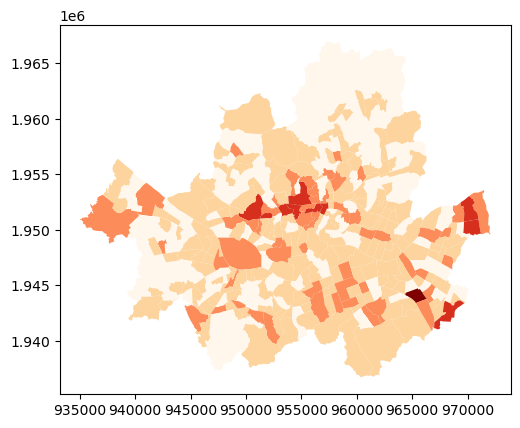

In [22]:
dongs.plot(
    column='총생활인구수',
    cmap='OrRd',
    scheme='natural_breaks')

In [23]:
parks = parks.to_crs("epsg:4326")
dongs = dongs.to_crs("epsg:4326")
dongs_list = ['Dongdaemun, Seoul, South Korea']

G = ox.graph_from_place(dongs_list, network_type='walk')
G.remove_nodes_from(list(nx.isolates(G)))

In [24]:
supply= utils.nearest_osm(G, parks)

100%|██████████████████████████████████| 155043/155043 [13:59<00:00, 184.72it/s]


In [25]:
demand= utils.nearest_osm(G, dongs)

100%|████████████████████████████████████████| 424/424 [00:02<00:00, 178.99it/s]


In [26]:
nodes, edges = ox.graph_to_gdfs(G, nodes = True, edges = True, node_geometry = True)

In [27]:
G = utils.network_settings_walk(G)

walk network set done


In [28]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)

In [29]:
weights = {5:1, 10:0.68, 15:0.22}  # keys: time, values: weight

result_step1 = utils.step1_E2SFCA(weights, supply, 'Area', demand, '총생활인구수', G)

100%|██████████████████████████████████| 155043/155043 [03:10<00:00, 814.44it/s]


In [30]:
result_step2 = utils.step2_E2SFCA(weights, result_step1, demand, G)

Processing demand points: 100%|███████████████| 424/424 [00:09<00:00, 46.88it/s]


In [31]:
result_step2

,SIDO_CD,SIDO_NM,SIGUNGU_CD,SIGUNGU_NM,ADM_CD,ADM_NM,geometry,총생활인구수,nearest_osm,access
0,11,서울특별시,11010,종로구,1101053,사직동,"POLYGON ((126.97399 37.57823, 126.974 37.57809...",646.165247,7.068765e+09,8.407788e+07
1,11,서울특별시,11010,종로구,1101054,삼청동,"POLYGON ((126.97714 37.59768, 126.9773 37.5976...",819.472895,5.191900e+09,1.312568e+08
2,11,서울특별시,11010,종로구,1101055,부암동,"POLYGON ((126.96253 37.60575, 126.96246 37.605...",622.595385,3.828659e+09,1.105710e+08
3,11,서울특별시,11010,종로구,1101056,평창동,"POLYGON ((126.97508 37.63118, 126.97468 37.629...",541.615290,3.828659e+09,1.105710e+08
4,11,서울특별시,11010,종로구,1101057,무악동,"POLYGON ((126.96079 37.57378, 126.96074 37.573...",389.776531,7.068765e+09,8.407788e+07
...,...,...,...,...,...,...,...,...,...,...
419,11,서울특별시,11250,강동구,1125070,둔촌1동,"POLYGON ((127.1448 37.51939, 127.14483 37.5192...",838.039244,1.245294e+10,5.784027e+07
420,11,서울특별시,11250,강동구,1125071,둔촌2동,"POLYGON ((127.15671 37.53758, 127.15654 37.537...",487.941971,1.239317e+10,3.527938e+07
421,11,서울특별시,11250,강동구,1125072,암사1동,"POLYGON ((127.13522 37.55473, 127.13569 37.554...",463.037580,9.587108e+09,1.018306e+08
422,11,서울특별시,11250,강동구,1125073,천호2동,"POLYGON ((127.11633 37.55005, 127.11642 37.550...",696.772748,1.239317e+10,3.527938e+07


In [32]:
result_step2_nor = result_step2.copy(deep=True)


min_sum = result_step2_nor['access'].min()
max_sum = result_step2_nor['access'].max()
# if 문을 통해 반복을 돌린다. 이를 하지 않았더니 똑같은 값만 나왔었다.
if max_sum == min_sum:
    print('틀렸다')
else:
    result_step2_nor['access_normalized'] = (result_step2_nor['access'] - min_sum) / (max_sum - min_sum)

In [33]:
result_step2_nor

,SIDO_CD,SIDO_NM,SIGUNGU_CD,SIGUNGU_NM,ADM_CD,ADM_NM,geometry,총생활인구수,nearest_osm,access,access_normalized
0,11,서울특별시,11010,종로구,1101053,사직동,"POLYGON ((126.97399 37.57823, 126.974 37.57809...",646.165247,7.068765e+09,8.407788e+07,0.351161
1,11,서울특별시,11010,종로구,1101054,삼청동,"POLYGON ((126.97714 37.59768, 126.9773 37.5976...",819.472895,5.191900e+09,1.312568e+08,0.593985
2,11,서울특별시,11010,종로구,1101055,부암동,"POLYGON ((126.96253 37.60575, 126.96246 37.605...",622.595385,3.828659e+09,1.105710e+08,0.487517
3,11,서울특별시,11010,종로구,1101056,평창동,"POLYGON ((126.97508 37.63118, 126.97468 37.629...",541.615290,3.828659e+09,1.105710e+08,0.487517
4,11,서울특별시,11010,종로구,1101057,무악동,"POLYGON ((126.96079 37.57378, 126.96074 37.573...",389.776531,7.068765e+09,8.407788e+07,0.351161
...,...,...,...,...,...,...,...,...,...,...,...
419,11,서울특별시,11250,강동구,1125070,둔촌1동,"POLYGON ((127.1448 37.51939, 127.14483 37.5192...",838.039244,1.245294e+10,5.784027e+07,0.216119
420,11,서울특별시,11250,강동구,1125071,둔촌2동,"POLYGON ((127.15671 37.53758, 127.15654 37.537...",487.941971,1.239317e+10,3.527938e+07,0.100001
421,11,서울특별시,11250,강동구,1125072,암사1동,"POLYGON ((127.13522 37.55473, 127.13569 37.554...",463.037580,9.587108e+09,1.018306e+08,0.442532
422,11,서울특별시,11250,강동구,1125073,천호2동,"POLYGON ((127.11633 37.55005, 127.11642 37.550...",696.772748,1.239317e+10,3.527938e+07,0.100001


<Axes: >

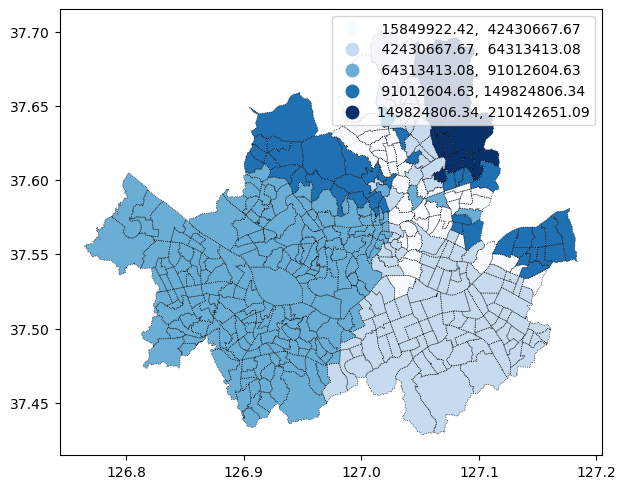

In [34]:
fig, ax = plt.subplots(figsize=(7, 7))

# 첫 번째 지도: demand_
result_step2_nor.plot(
    column='access',
    ax=ax,
    legend=True,
    cmap='Blues',
    scheme='FisherJenks'
)
result_step2_nor.boundary.plot(
    ax=ax,
    linestyle='dotted',
    lw=0.5,
    color='black',
    zorder=1
)